# TCN Model Experiment Notebook

This notebook demonstrates how to run an experiment for the Temporal Convolutional Network (TCN) model for time series forecasting using configuration files. We'll go through the following steps:

1. Setting up the environment
2. Loading and exploring the dataset
3. Loading configurations from JSON files
4. Setting up the TCN model
5. Training the model
6. Evaluating the model
7. Visualizing the results


## 1. Setting up the environment

First, let's import the necessary libraries and set up the environment.


In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys

# Add the parent directory to the path so we can import from the project
sys.path.append('..')

from exp.exp_main import Exp_Main
from data_provider.data_factory import data_provider
from utils.tools import visual
from utils.metrics import metric
from utils.config_loader import load_config

# Set random seed for reproducibility
fix_seed = 2025
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)


## 2. Loading and exploring the dataset

Let's load and explore the dataset we'll be using for our experiment.


In [2]:
# Define the dataset path
root_path = '../dataset/'
data_path = 'data-com-latest.csv'  # You can change this to your dataset

# Load the dataset
df = pd.read_csv(os.path.join(root_path, data_path))
print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (8474, 10)


CO2  Temperature  Humidity  Sun1  Sun2   Sun3   Sun4   Sun5  Sun6  \
0  473.0         25.2      45.1  77.3  86.7  115.6  103.0  110.1  98.3   
1  465.0         25.3      42.1  77.5  84.1  120.1  101.0  109.3  97.7   
2  499.0         25.1      40.5  77.2  84.4  119.9  100.8  109.2  97.9   
3  536.0         24.9      40.7  78.3  82.9  119.7  102.2  110.0  97.5   
4  530.0         24.8      40.4  79.3  84.5  115.4  105.6  111.2  97.8   

                  date  
0  2025-04-26 16:53:56  
1  2025-04-26 16:58:56  
2  2025-04-26 17:03:56  
3  2025-04-26 17:08:56  
4  2025-04-26 17:13:56

In [3]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
df.describe()


Missing values in each column:
CO2            0
Temperature    0
Humidity       0
Sun1           0
Sun2           0
Sun3           0
Sun4           0
Sun5           0
Sun6           0
date           0
dtype: int64

Basic statistics:


CO2  Temperature     Humidity         Sun1         Sun2  \
count  8474.000000  8474.000000  8474.000000  8474.000000  8474.000000   
mean    567.271772    22.084435    75.907600   676.180458   954.076988   
std      93.394182     3.516167    19.725459  1438.020935  1647.528279   
min     386.000000    11.500000    36.800000     0.000000     0.000000   
25%     489.000000    19.400000    57.800000     0.000000     0.000000   
50%     575.000000    22.000000    72.900000    96.800000   104.700000   
75%     638.000000    24.800000    97.500000   101.000000   109.200000   
max     828.000000    34.100000   100.000000  3999.900000  3999.900000   

              Sun3         Sun4         Sun5         Sun6  
count  8474.000000  8474.000000  8474.000000  8474.000000  
mean    841.979313    49.273602   535.803163    46.387279  
std    1561.915298    51.062297  1286.057987    48.047154  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000  
50%     116.200000     0.000000   106.400000     0.000000  
75%     119.800000   102.000000   108.600000    95.800000  
max    3999.900000   113.800000  3999.900000   105.400000

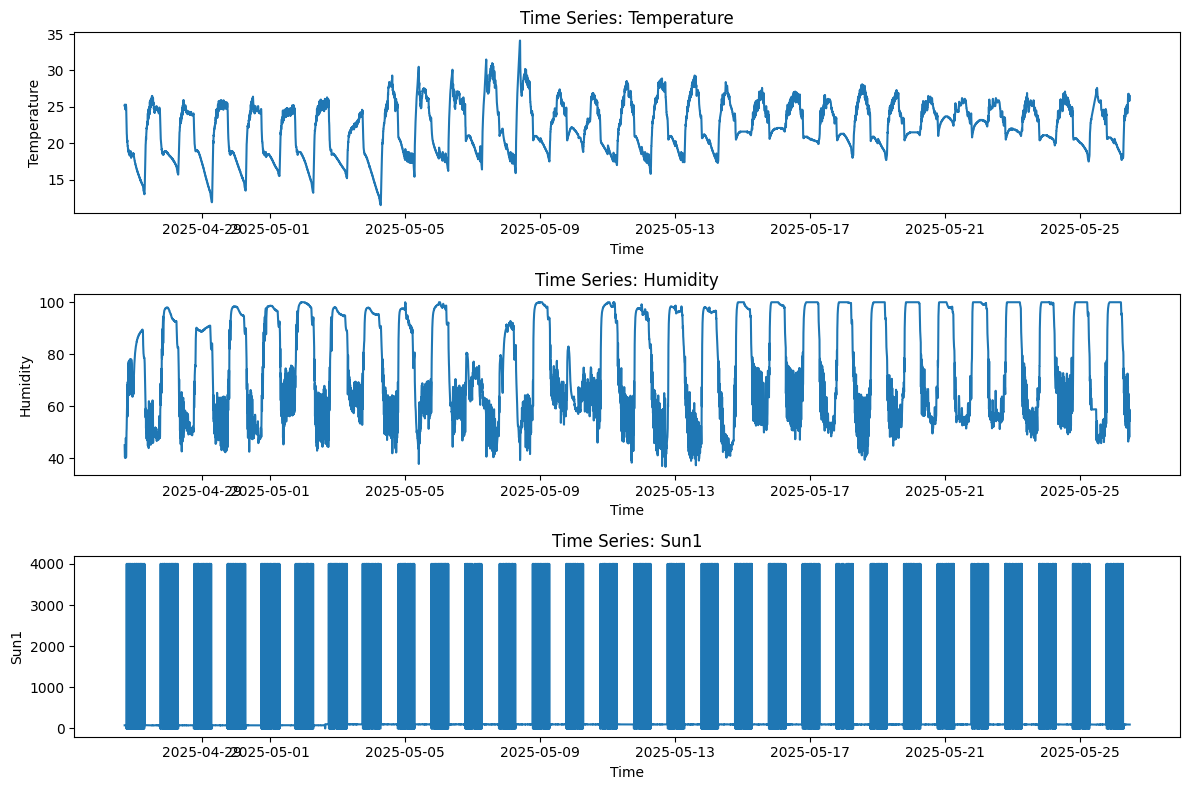

In [4]:
# Visualize the time series data
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    
    # Plot a few columns
    plt.figure(figsize=(12, 8))
    for i, col in enumerate(df.columns[1:4]):  # Plot first 3 columns after Datetime
        plt.subplot(3, 1, i+1)
        plt.plot(df['date'], df[col])
        plt.title(f'Time Series: {col}')
        plt.xlabel('Time')
        plt.ylabel(col)
    plt.tight_layout()
    plt.show()


## 3. Loading configurations from JSON files

Now, let's load the model and experiment configurations from JSON files.


In [5]:
# Load the model and experiment configurations
model_name = 'tcn'  # The model name (tcn)
config_model_path = '../config/model/tcn.json'  # Path to the model configuration file
config_experiment_path = '../config/experiment/multivariate.json'

# Load the configuration
args = load_config(config_model_path, config_experiment_path)

# Update paths to be relative to the notebook
args.root_path = args.root_path.replace('./', '../')
args.checkpoints = args.checkpoints.replace('./', '../')

# Display the configuration
print(f"Model Configuration loaded from: config/model/{config_model_path}.json")
print(f"Experiment Configuration loaded from: config/experiment/{config_experiment_path}.json")
print(args)


Model Configuration loaded from: config/model/../config/model/tcn.json.json
Experiment Configuration loaded from: config/experiment/../config/experiment/multivariate.json.json
namespace(model_name='TCN', d_model=512, n_heads=8, e_layers=2, d_layers=1, d_ff=2048, factor=1, dropout=0.05, activation='gelu', output_attention=False, experiment_name='multivariate_experiment', is_training=1, is_pretrain=0, is_finetune=0, pretrained_model=None, model_id='run_tcn', data='custom', root_path='../dataset/', data_path='data-com-latest.csv', target='CO2', freq='h', checkpoints='../experiments/model_saved/checkpoints/', features='M', embed='timeF', seq_len=96, label_len=48, pred_len=96, enc_in=9, dec_in=9, c_out=9, num_workers=0, itr=1, train_epochs=100, batch_size=32, patience=3, learning_rate=0.0001, des='multivariate', loss='mse', lradj='type1', use_amp=False, use_gpu=True, gpu=0, use_multi_gpu=False, devices='0', device_ids=[0], model='TCN')


## 4. Setting up the TCN model

Now, let's set up the TCN model using the loaded configurations.


In [6]:
# Create experiment setting
def get_exp_setting(args):
    return '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_{}'.format(
        args.model_id, args.model, args.data, args.features, args.seq_len, args.label_len,
        args.pred_len, args.d_model, args.n_heads, args.e_layers, args.d_layers,
        args.d_ff, args.factor, args.embed, args.des)

setting = f'{get_exp_setting(args)}_0'
print(f"Experiment setting: {setting}")


Experiment setting: run_tcn_TCN_custom_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_multivariate_0


In [7]:
# Create experiment instance
exp = Exp_Main(args, setting=setting)

# Print model summary
print("Model Architecture:")
model = exp.model
print(model)


Use GPU: cuda:0
TCN
Layer (type:depth-idx)                   Param #
Model                                    --
├─Linear: 1-1                            5,120
├─TemporalConvNet: 1-2                   --
│    └─Sequential: 2-1                   --
│    │    └─TemporalBlock: 3-1           1,573,888
│    │    └─TemporalBlock: 3-2           1,573,888
├─Linear: 1-3                            5,120
├─Linear: 1-4                            4,617
├─Linear: 1-5                            9,312
Total params: 6,319,721
Trainable params: 6,319,721
Non-trainable params: 0
Model Architecture:
Model(
  (enc_embedding): Linear(in_features=9, out_features=512, bias=True)
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.05, inplace=False)
        (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2

## 5. Training the model

Now, let's train the TCN model.


In [8]:
# Train the model
best_model_path = exp.train(setting)
print(f"Training completed. Best model saved at: {best_model_path}")


Loading data...
train DataLoader length: 153
train DataLoader batch size: 32
train DataLoader dataset length: 4893
train DataLoader dataset features: M
train DataLoader dataset target: CO2
train DataLoader dataset freq: h
train DataLoader dataset timeenc: 1
train DataLoader drop_last: False
train DataLoader shuffle: True
val DataLoader length: 51
val DataLoader batch size: 32
val DataLoader dataset length: 1601
val DataLoader dataset features: M
val DataLoader dataset target: CO2
val DataLoader dataset freq: h
val DataLoader dataset timeenc: 1
val DataLoader drop_last: False
val DataLoader shuffle: True
test DataLoader length: 1599
test DataLoader batch size: 1
test DataLoader dataset length: 1599
test DataLoader dataset features: M
test DataLoader dataset target: CO2
test DataLoader dataset freq: h
test DataLoader dataset timeenc: 1
test DataLoader drop_last: False
test DataLoader shuffle: False
Train data size: 4893
Validation data size: 1601
Test data size: 1599
	iters: 100, epoch: 

## 6. Evaluating the model

Now, let's evaluate the trained model on the test dataset.


Evaluating model on test data...
test DataLoader length: 1599
test DataLoader batch size: 1
test DataLoader dataset length: 1599
test DataLoader dataset features: M
test DataLoader dataset target: CO2
test DataLoader dataset freq: h
test DataLoader dataset timeenc: 1
test DataLoader drop_last: False
test DataLoader shuffle: False
loading model
test shape: (1599, 96, 9)
mse:1.030307650566101, mae:0.7537301182746887, rmse:1.0150407552719116, mape:1.5808055400848389, mspe:207.00643920898438
All the logs saved at ./experiments/model_saved/results/run_tcn_TCN_custom_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_multivariate_0/


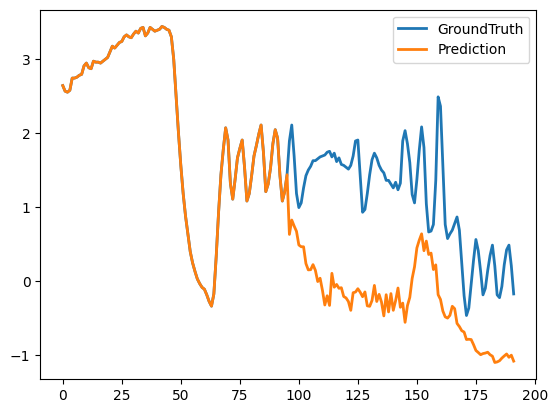

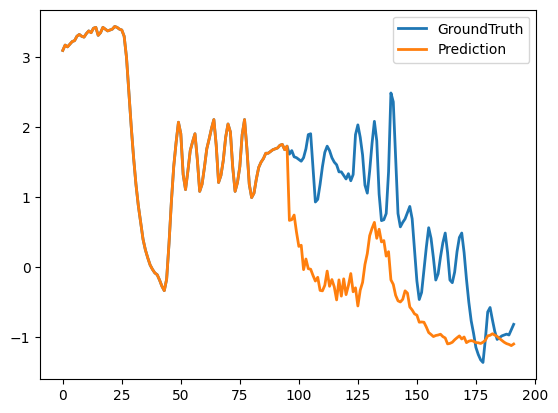

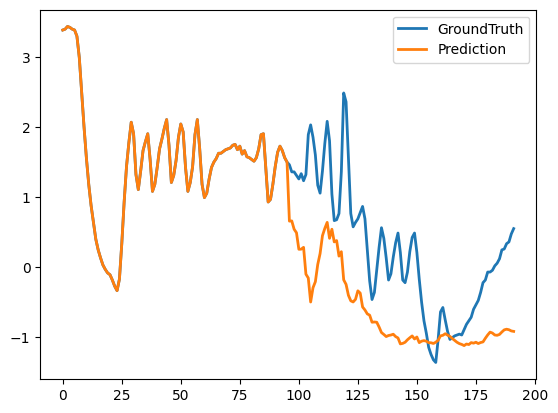

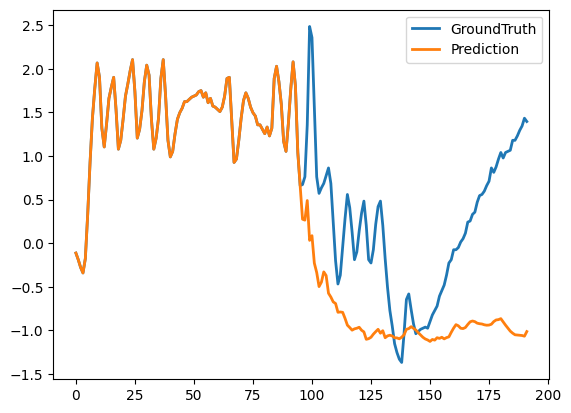

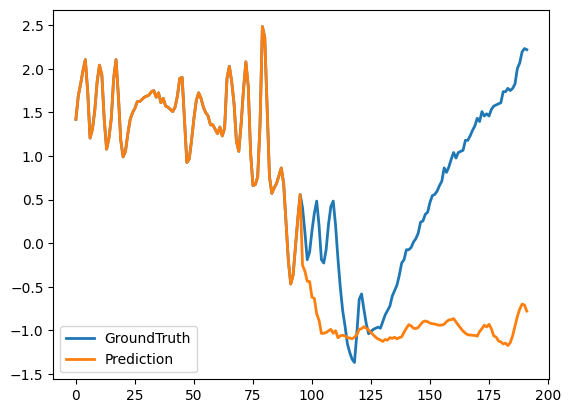

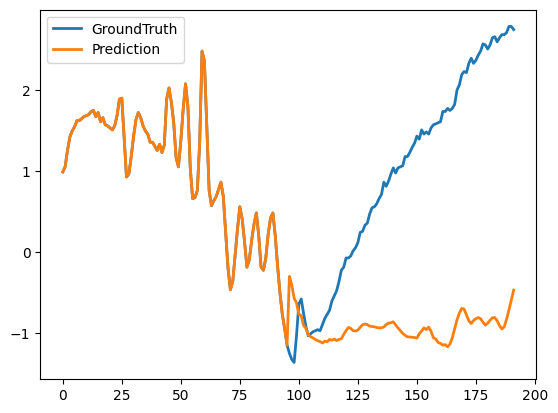

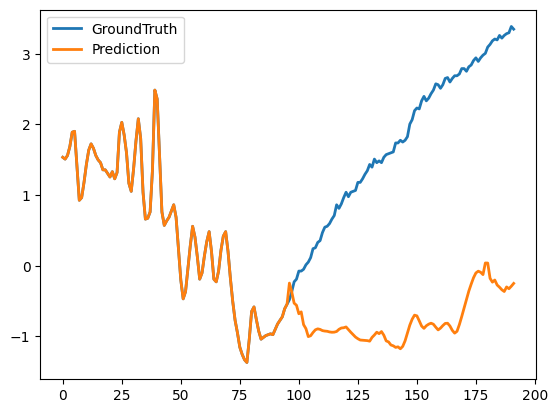

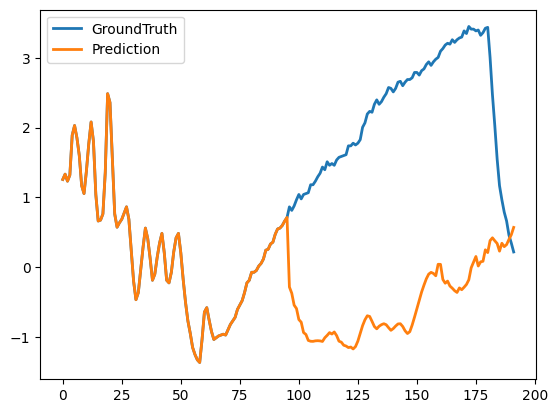

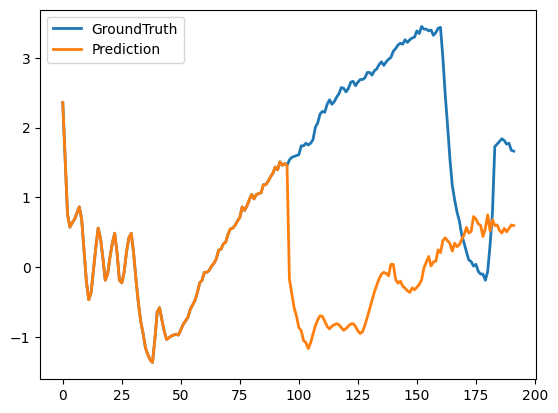

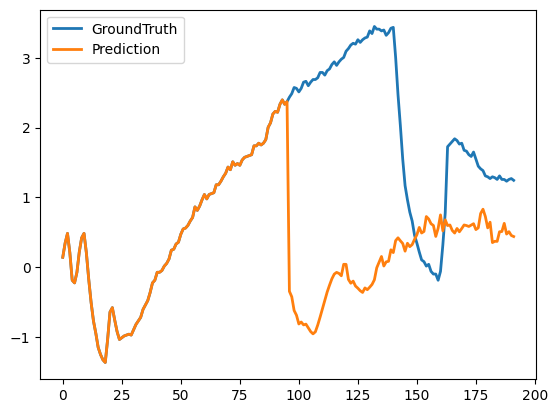

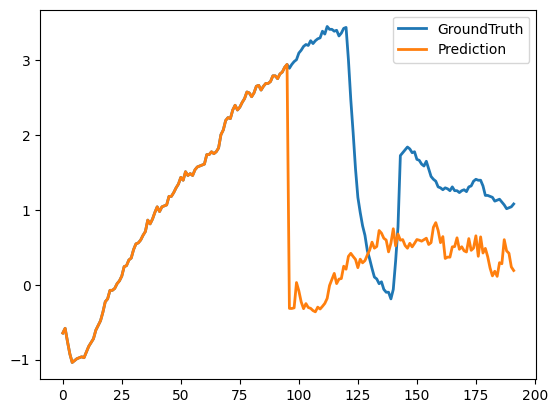

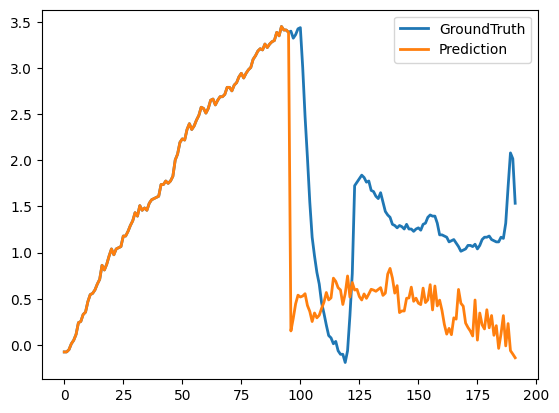

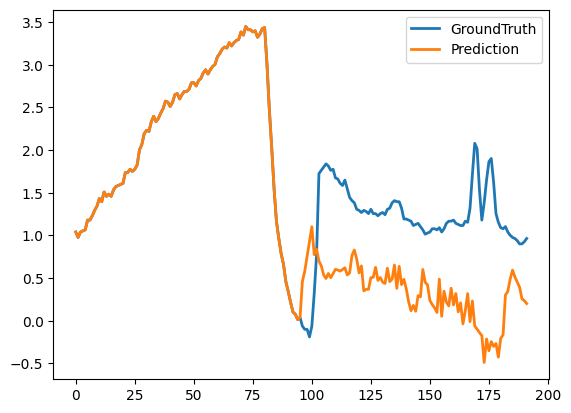

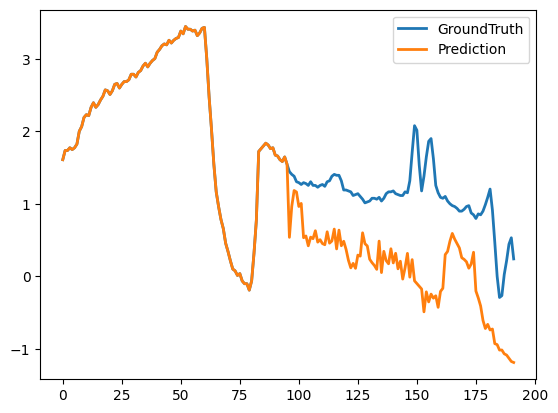

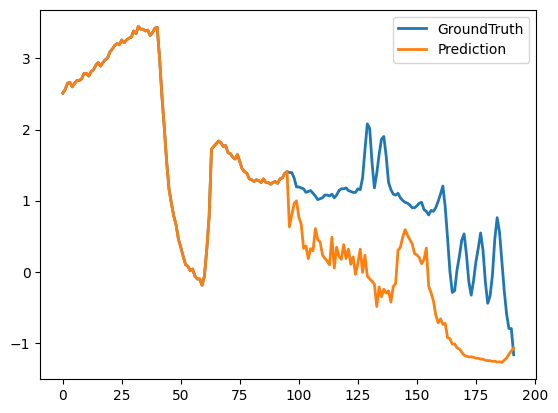

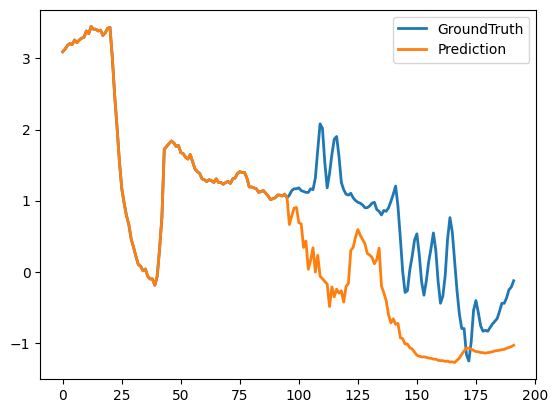

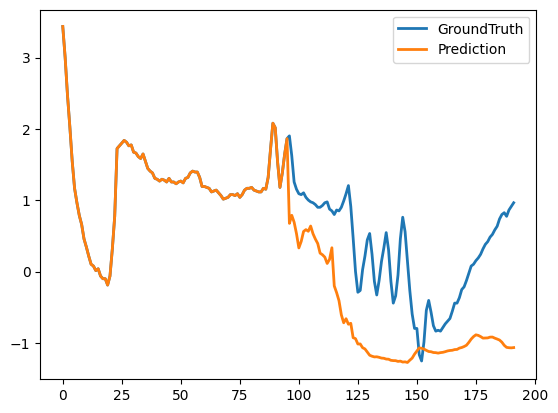

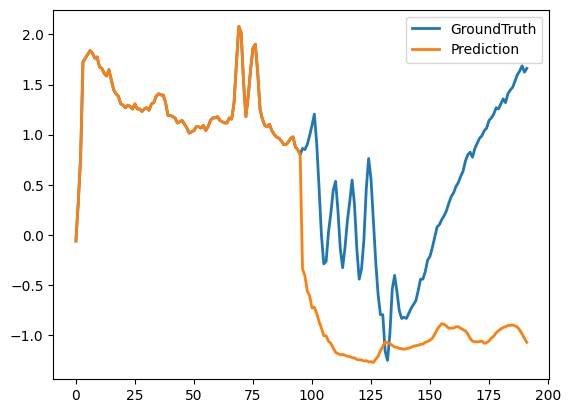

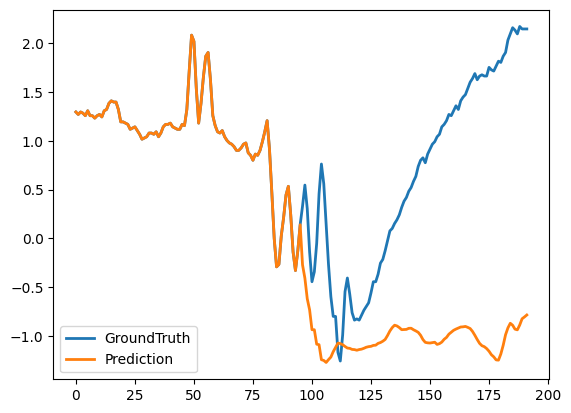

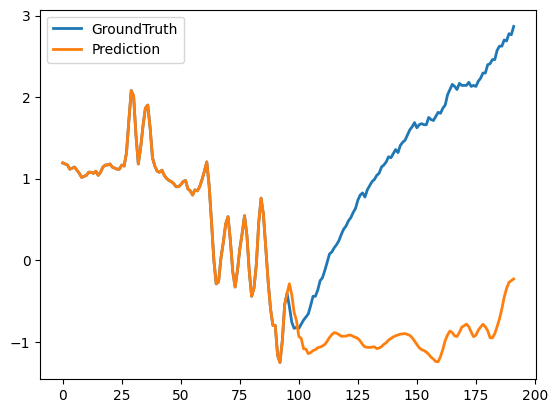

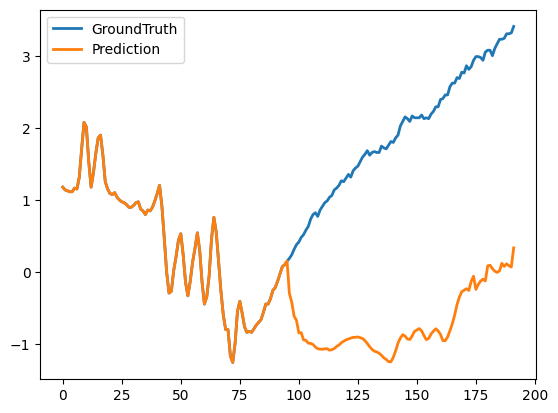

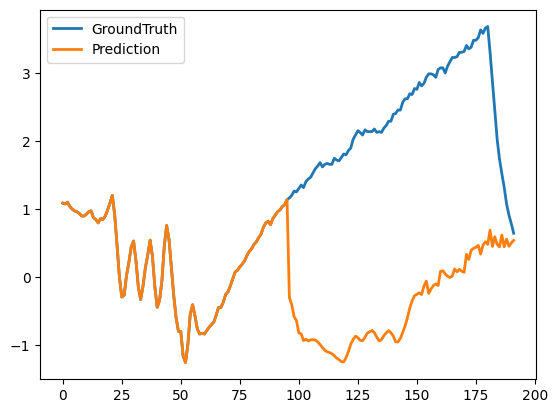

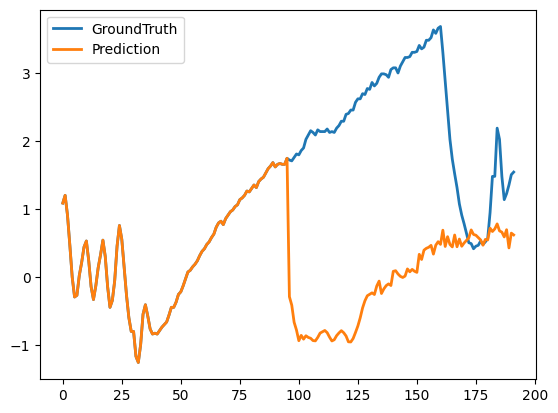

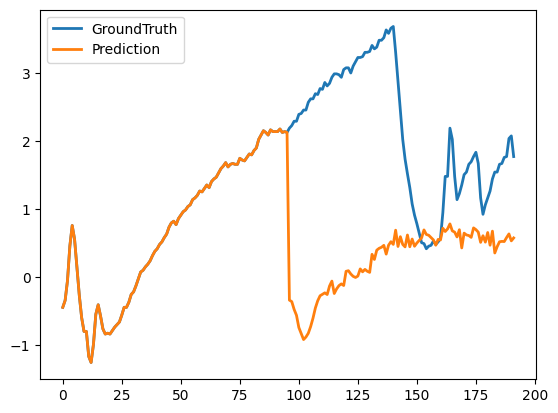

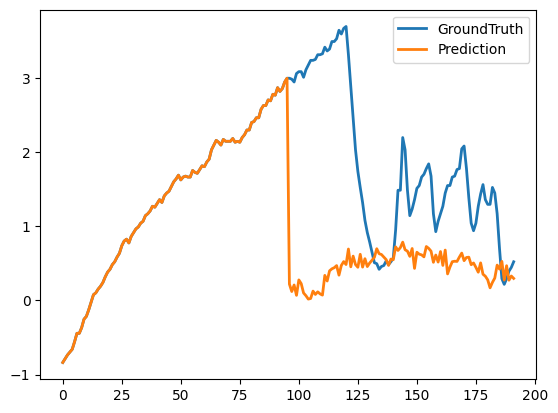

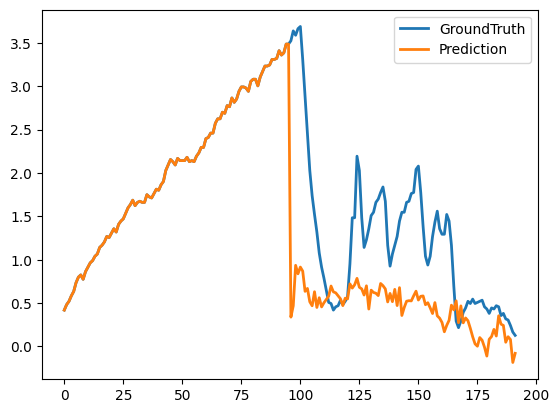

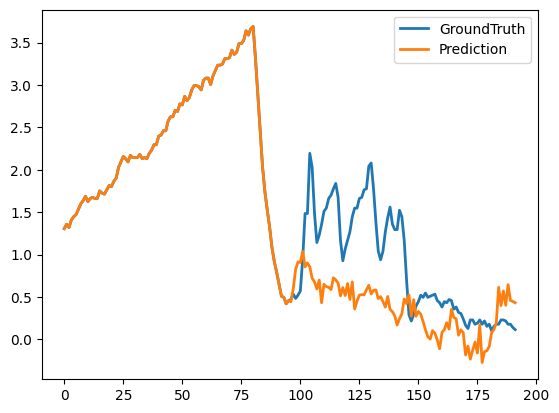

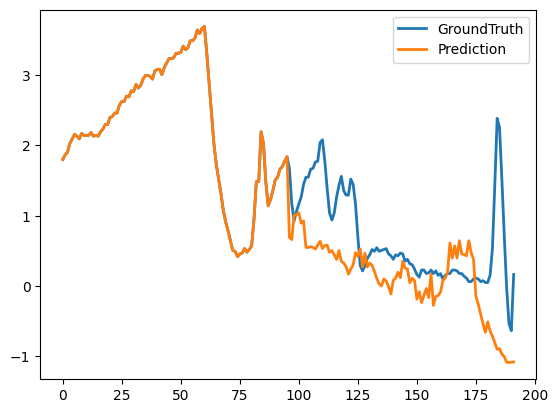

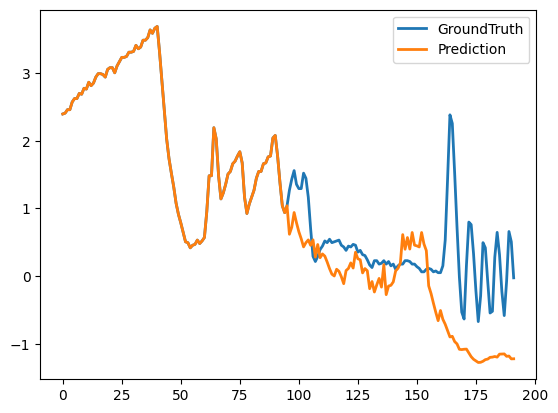

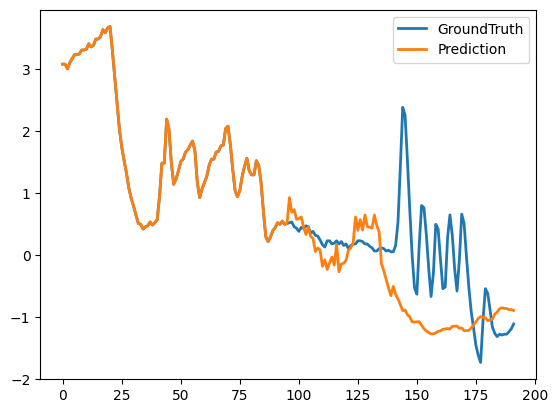

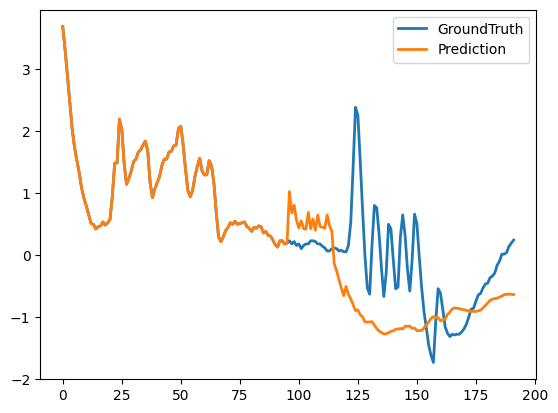

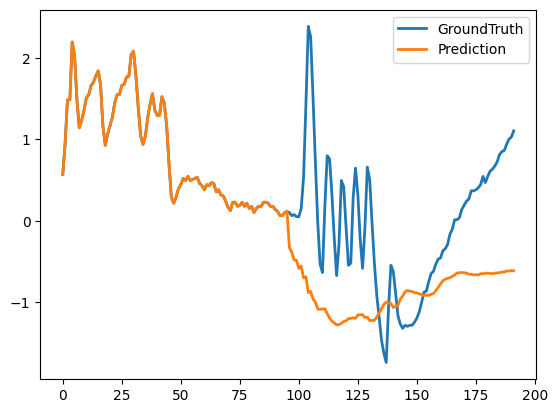

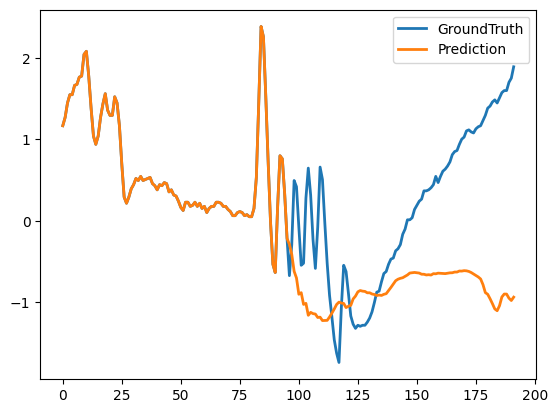

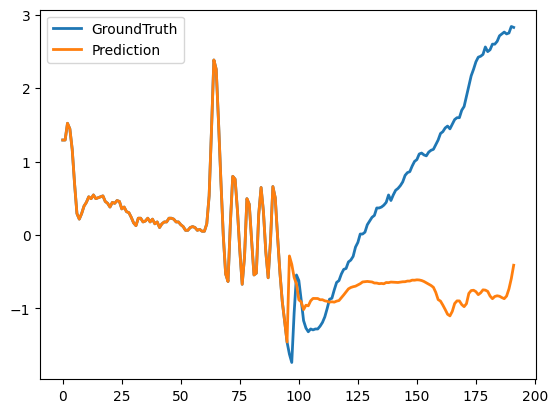

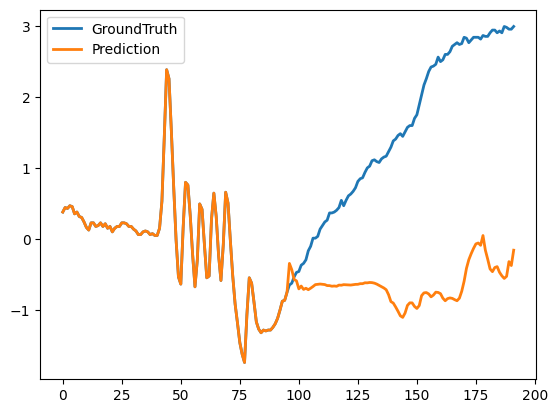

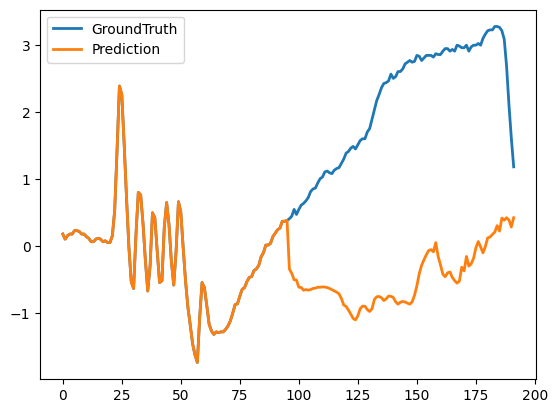

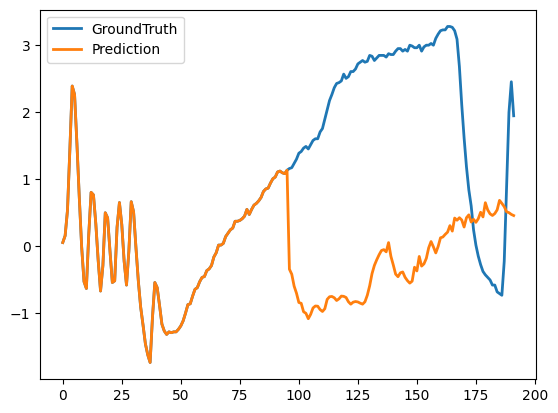

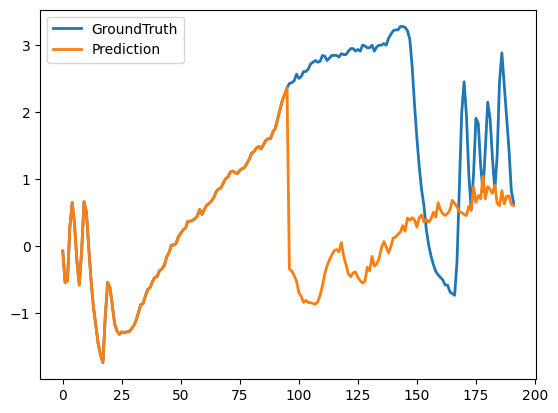

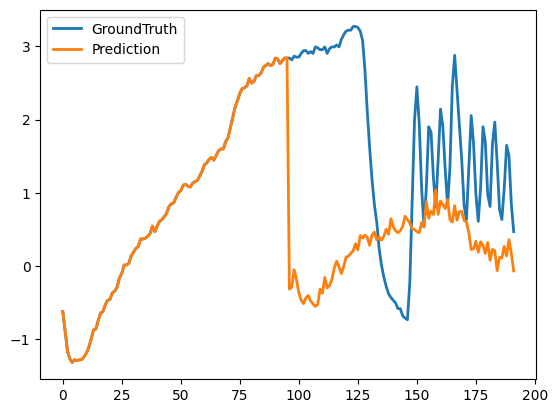

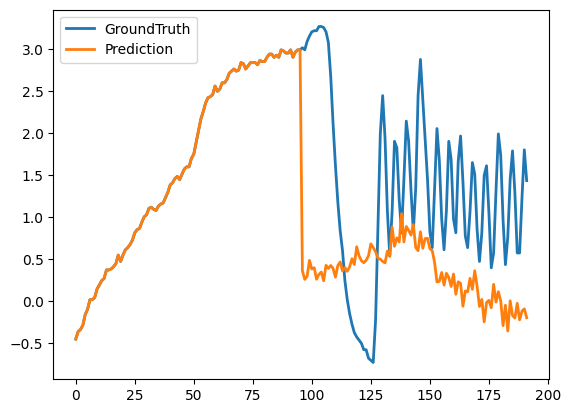

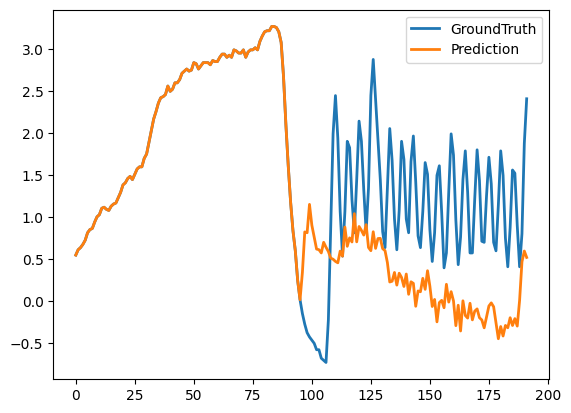

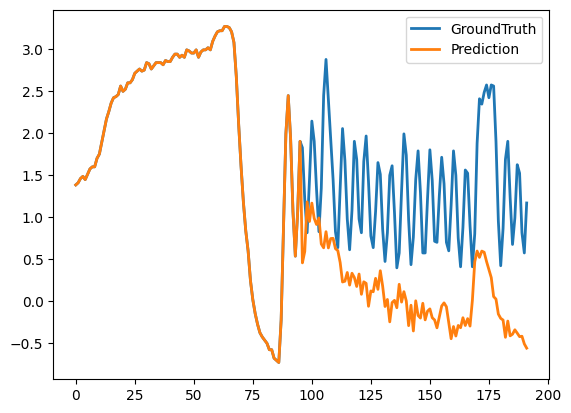

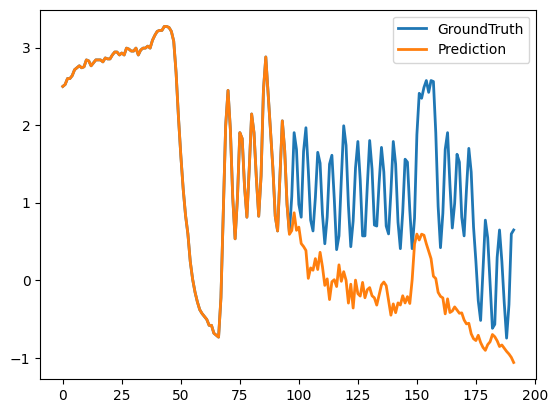

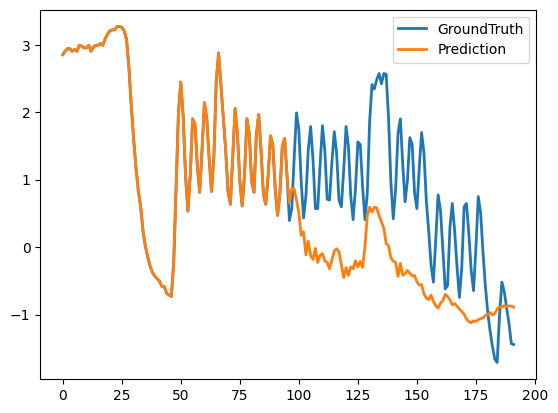

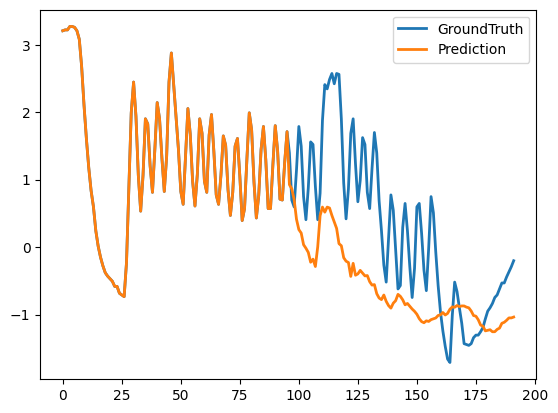

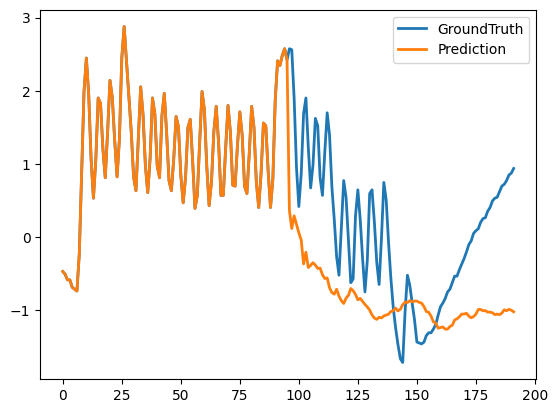

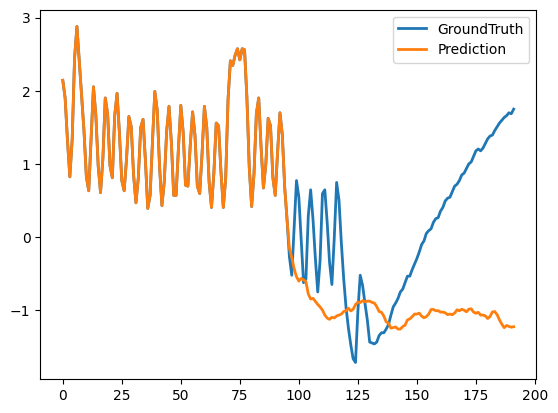

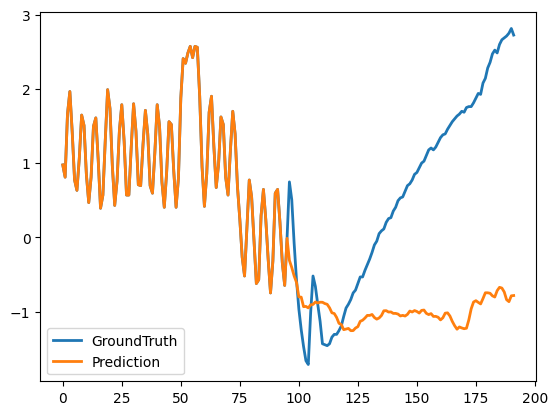

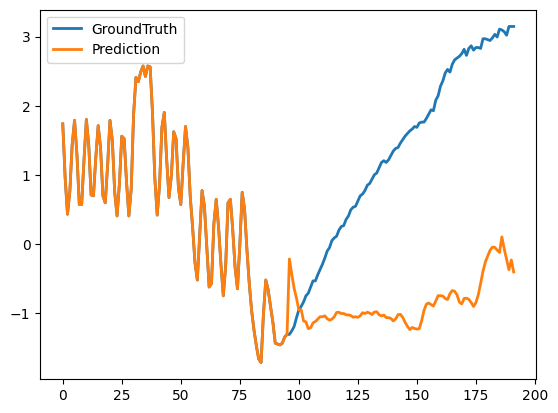

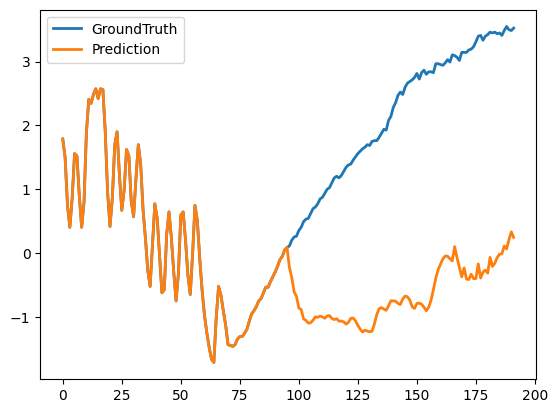

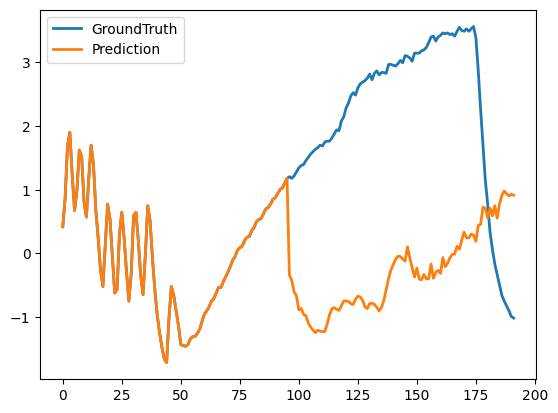

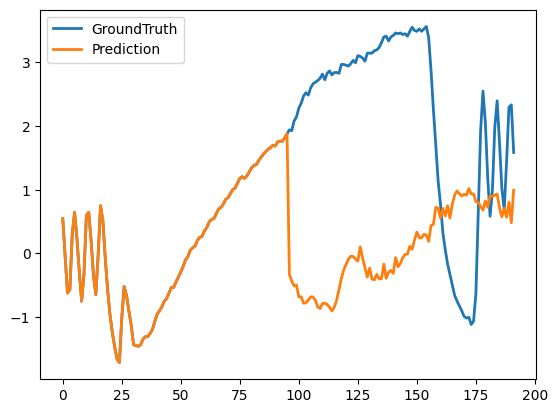

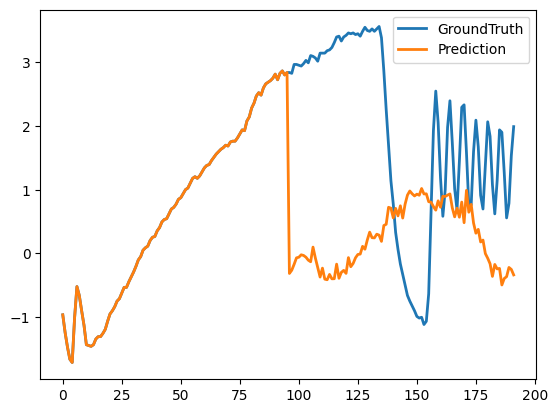

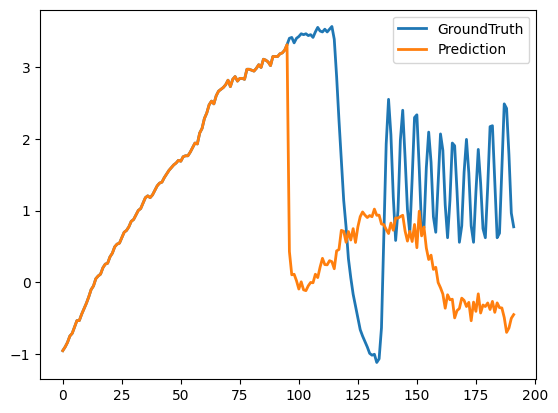

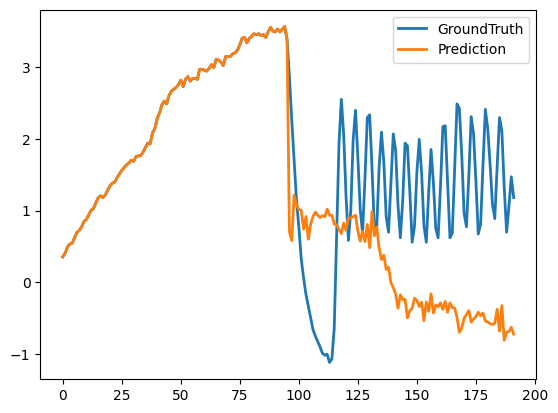

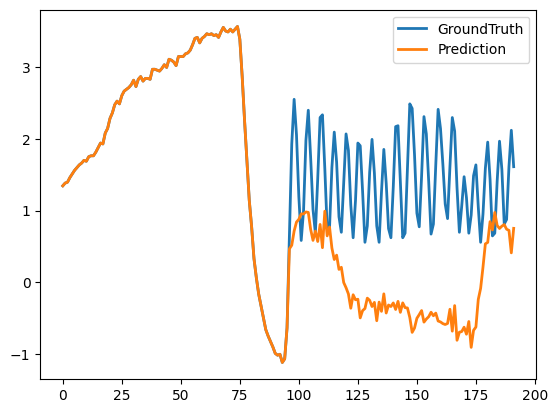

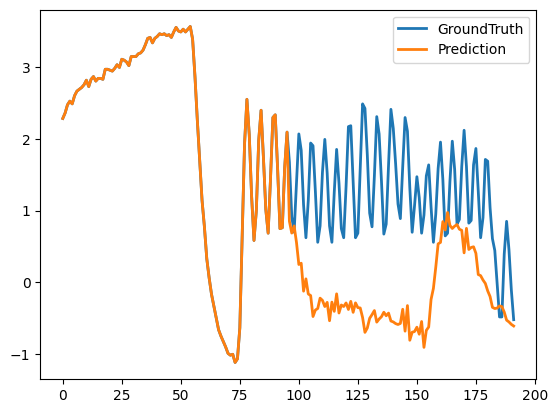

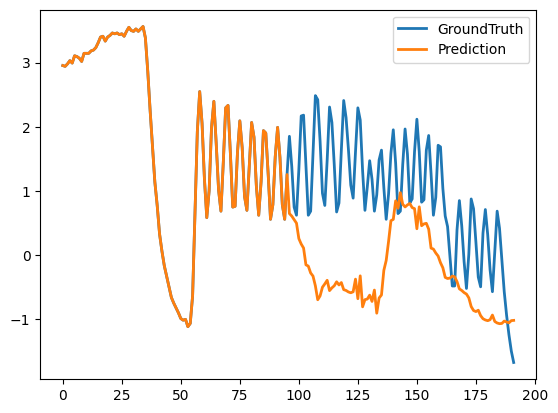

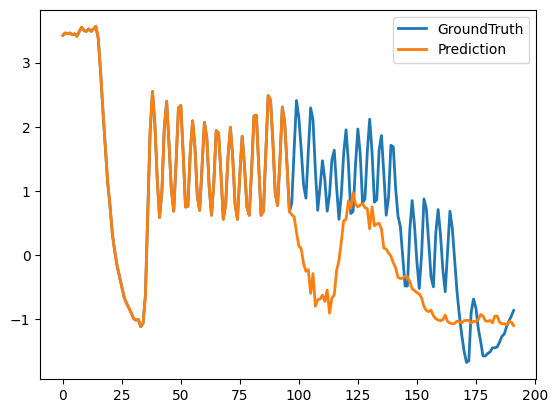

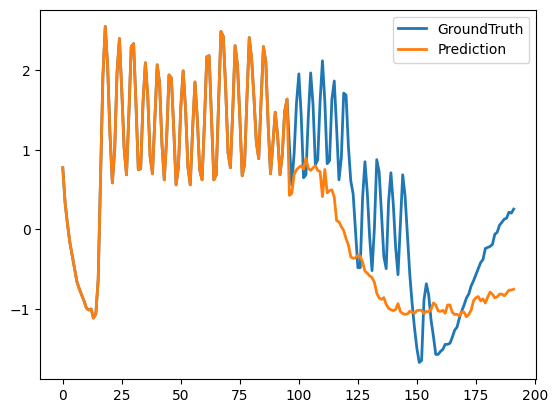

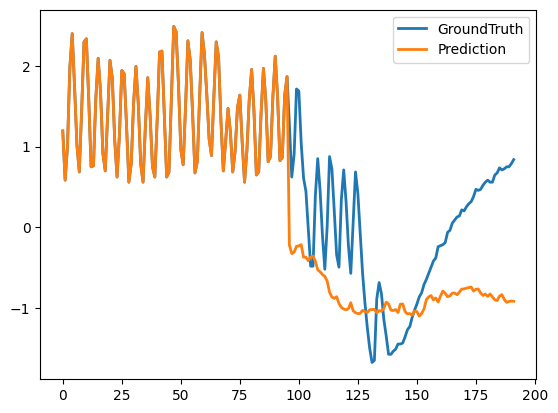

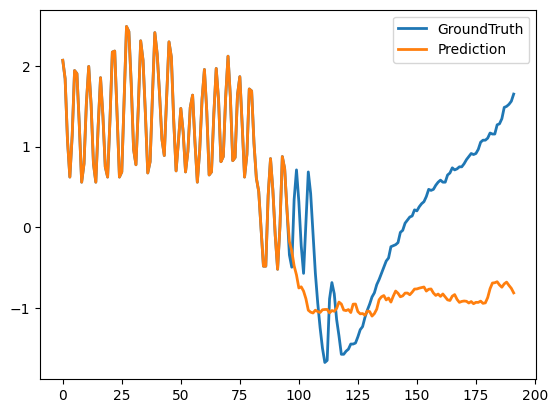

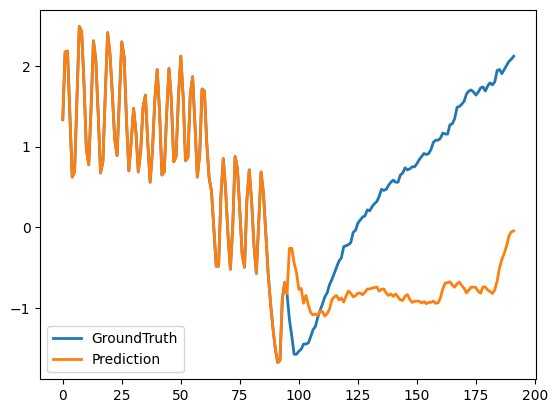

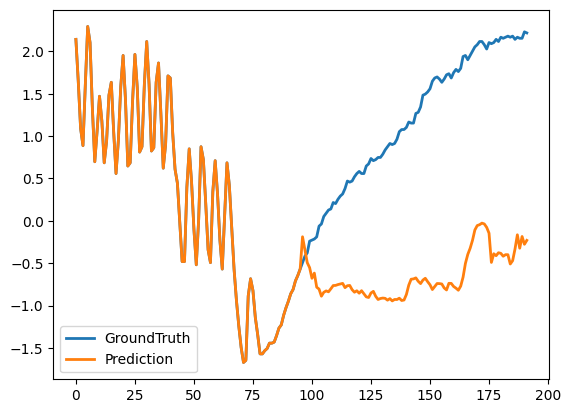

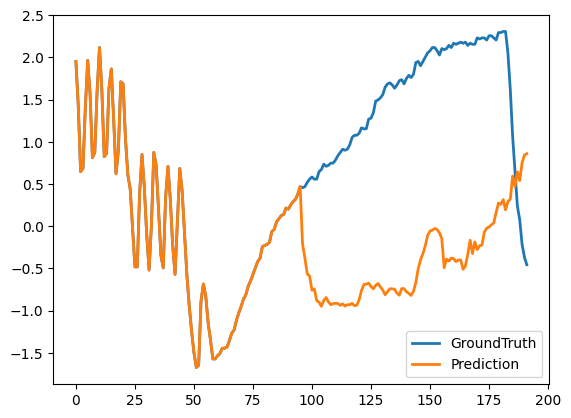

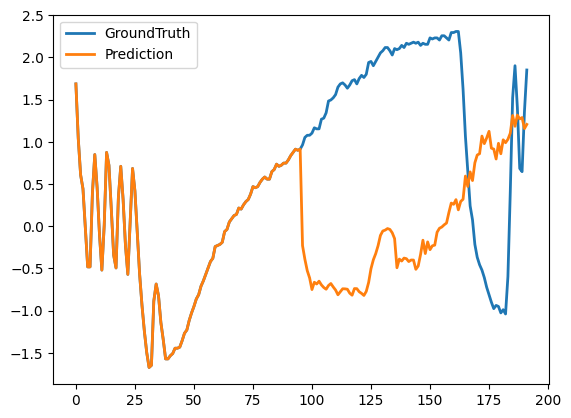

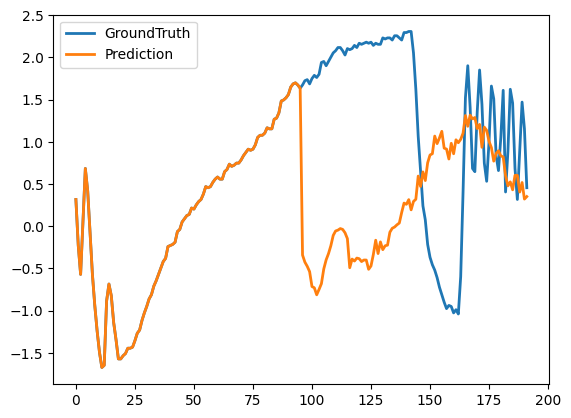

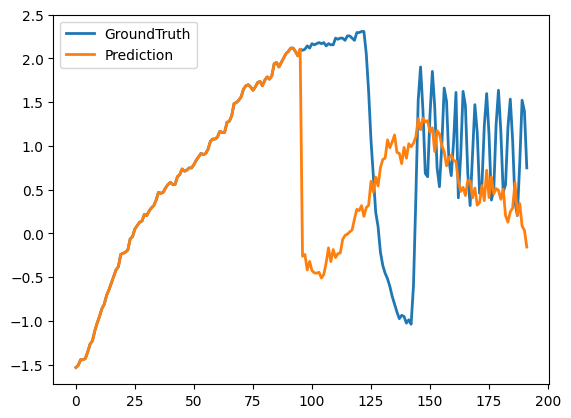

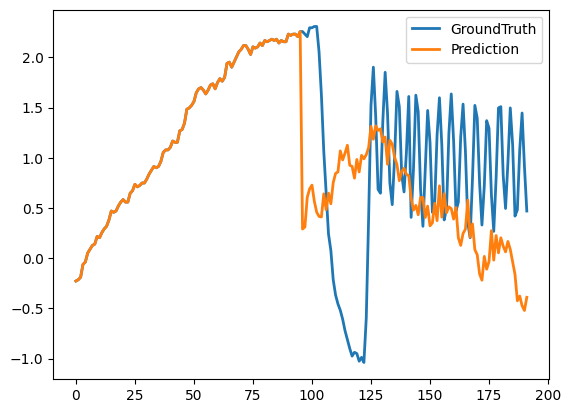

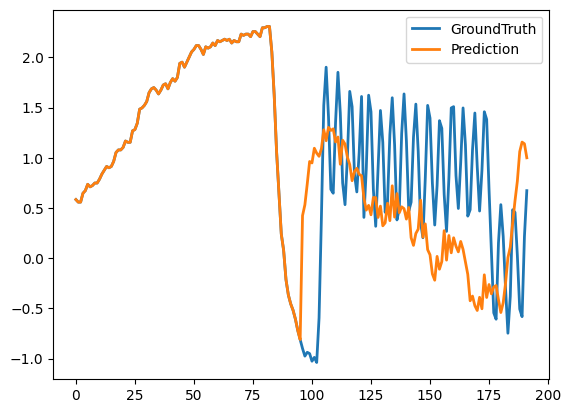

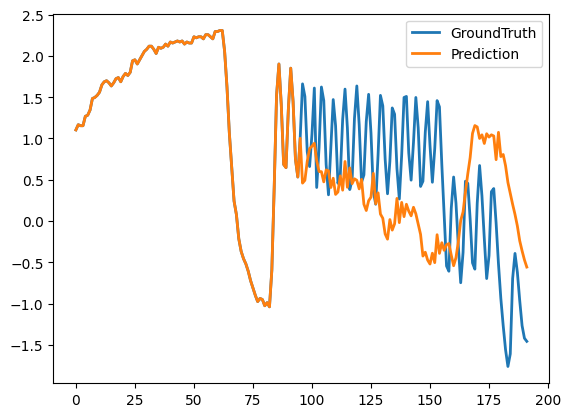

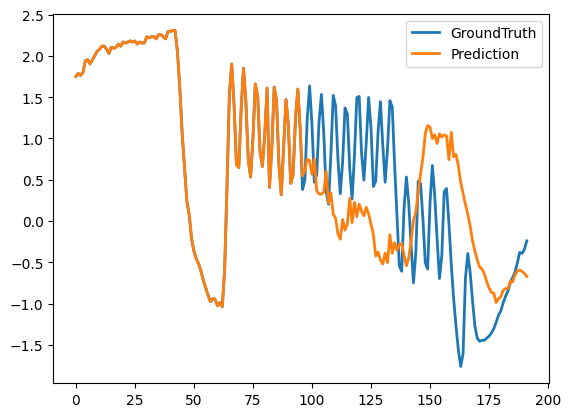

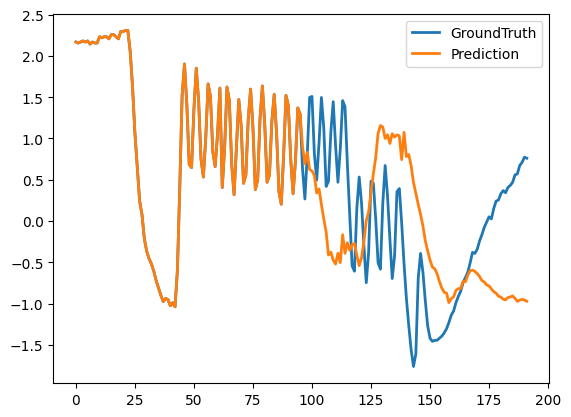

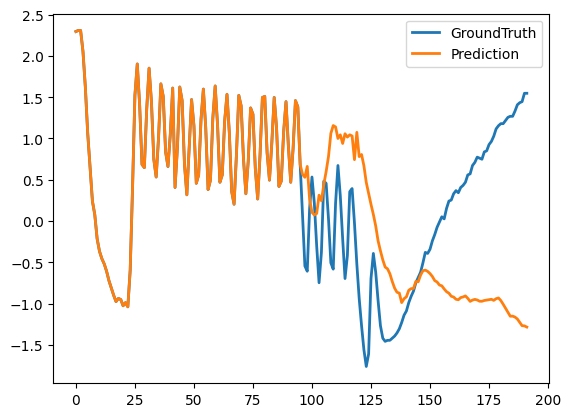

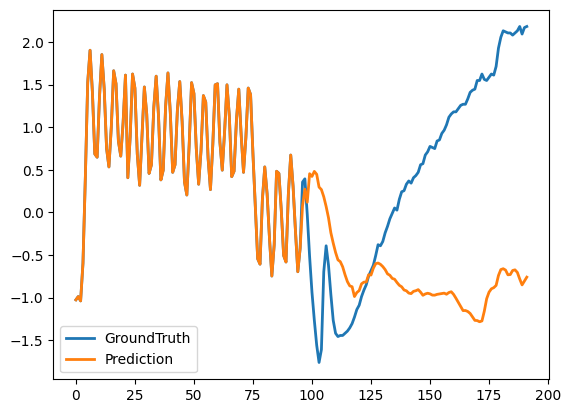

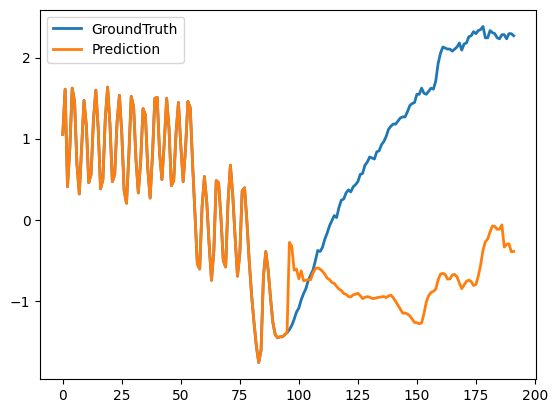

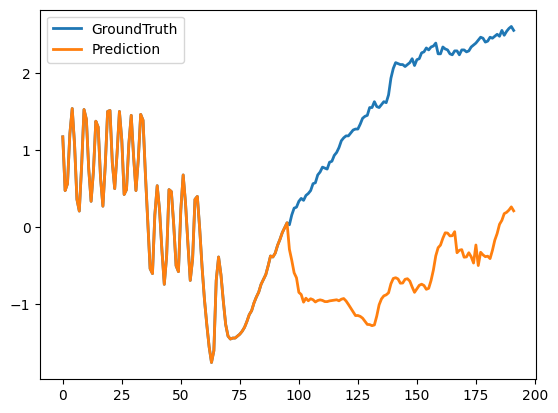

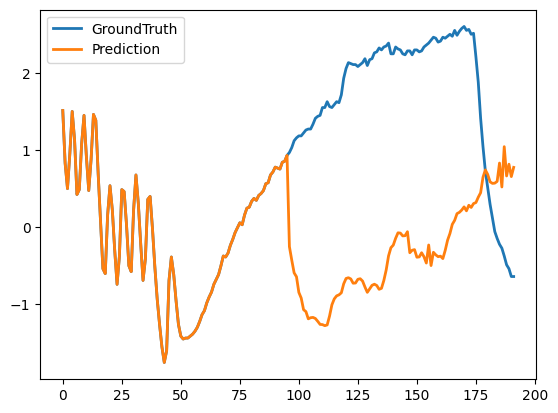

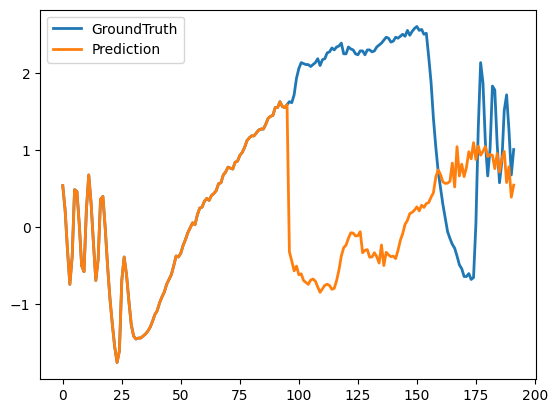

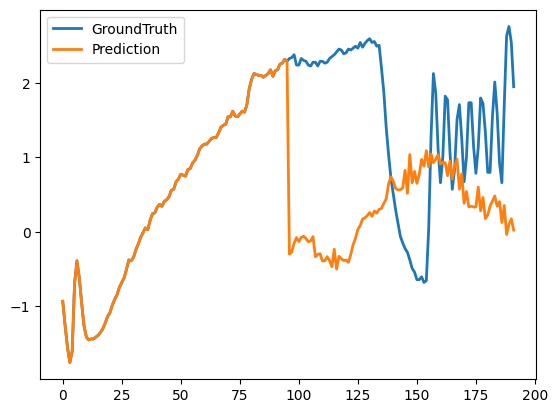

In [9]:
# Test the model
print("Evaluating model on test data...")
exp.test(setting, best_model_path)


## 7. Visualizing the results

Finally, let's visualize the forecasting results.


In [13]:
# Load test results
folder_path = f'./experiments/model_saved/results/{setting}/'
preds = np.load(os.path.join(folder_path, 'pred.npy'))
trues = np.load(os.path.join(folder_path, 'true.npy'))

print(f"Predictions shape: {preds.shape}")
print(f"True values shape: {trues.shape}")


Predictions shape: (1599, 96, 9)
True values shape: (1599, 96, 9)


In [14]:
# Calculate metrics
mae, mse, rmse, mape, mspe = metric(preds, trues)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'MSPE: {mspe}')


MAE: 0.7537301182746887
MSE: 1.030307650566101
RMSE: 1.0150407552719116
MAPE: 1.5808055400848389
MSPE: 207.00643920898438


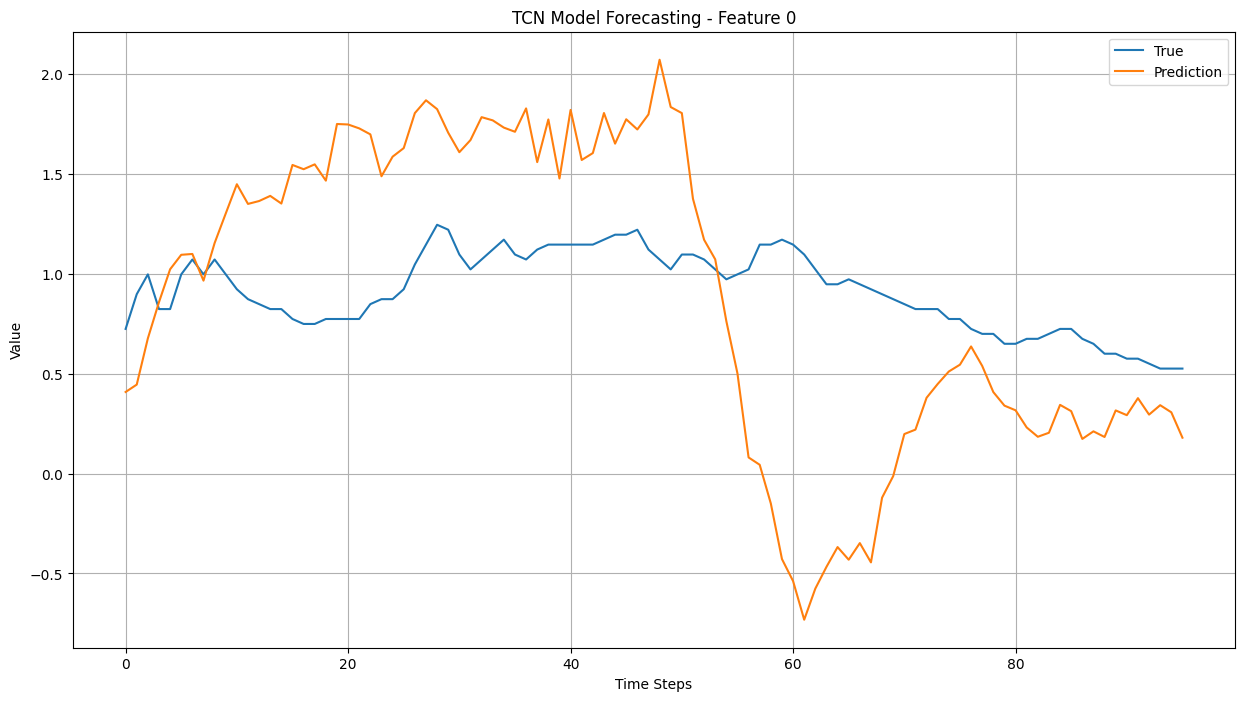

In [15]:
# Visualize predictions vs true values
# Select a sample for visualization
sample_idx = 0

plt.figure(figsize=(15, 8))
if args.features == 'M' or args.features == 'MS':
    feature_idx = 0  # Index of the feature to visualize
    plt.plot(trues[sample_idx, :, feature_idx], label='True')
    plt.plot(preds[sample_idx, :, feature_idx], label='Prediction')
    plt.title(f'TCN Model Forecasting - Feature {feature_idx}')
else:  # 'S'
    plt.plot(trues[sample_idx, :, 0], label='True')
    plt.plot(preds[sample_idx, :, 0], label='Prediction')
    plt.title('TCN Model Forecasting')
    
plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.grid(True)
plt.show()


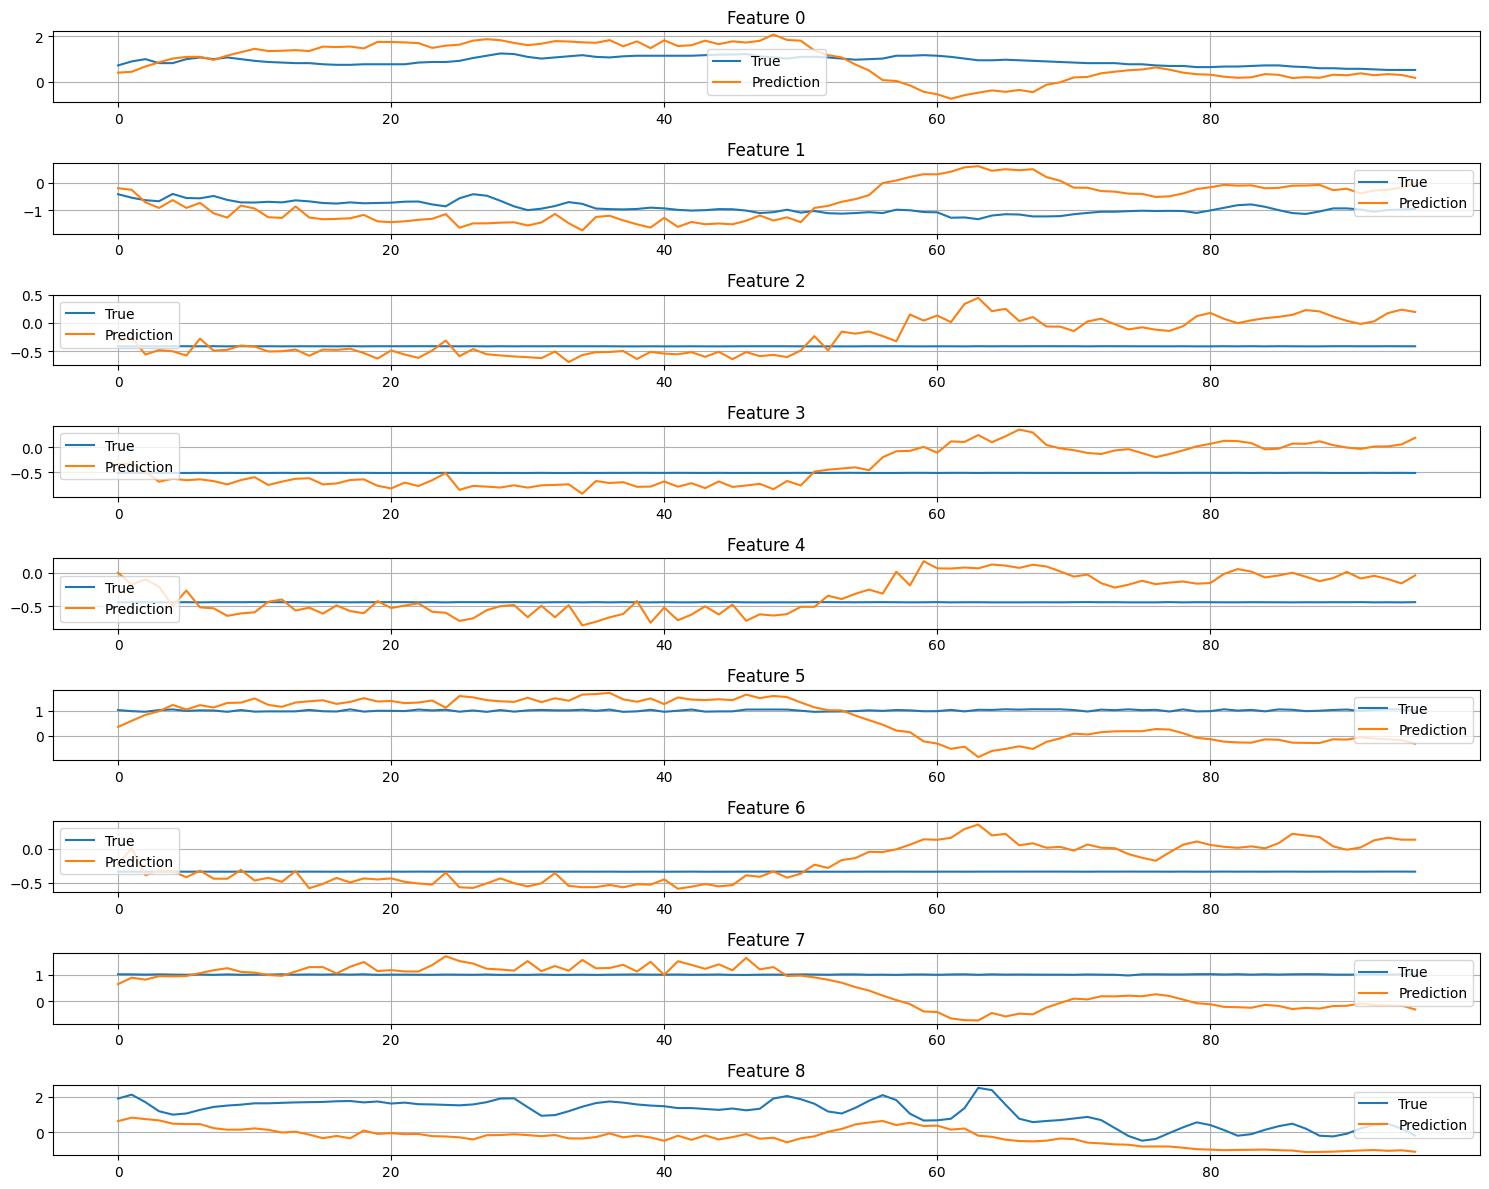

In [18]:
# Visualize multiple features if using multivariate forecasting
if args.features == 'M':
    plt.figure(figsize=(15, 12))
    for i in range(args.enc_in):
        plt.subplot(args.enc_in, 1, i + 1)
        plt.plot(trues[sample_idx, :, i], label='True')
        plt.plot(preds[sample_idx, :, i], label='Prediction')
        plt.title(f'Feature {i}')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()


## Conclusion

In this notebook, we've demonstrated how to run an experiment for the TCN model using configuration files. We've gone through the following steps:

1. Set up the environment and imported necessary libraries
2. Loaded and explored the dataset
3. Loaded model and experiment configurations from JSON files
4. Set up the TCN model using the loaded configurations
5. Trained the model on the training dataset
6. Evaluated the model on the test dataset
7. Visualized the forecasting results

This approach allows for easy experimentation with different model and experiment configurations by simply changing the configuration files, without having to modify the code.